In [1]:
#IPython extension to reload modules before executing user code. If we make any change in function 
# and imoprting it we don't need to restart if we use auto reload 
%load_ext autoreload

# to print in between values as well without print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [29]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn


# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import pickle
from sklearn.metrics import classification_report
from pprint import pprint as pp


# scipy
from scipy.stats import boxcox

# yellowbrick
from yellowbrick.classifier import ROCAUC

# Supporting Functions

In [6]:
# to save pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))

In [7]:
# to load
def load_pkl_model(path):
    sc = pickle.load(open(path,'rb'))
    return sc

In [8]:
def preprocess_pipeline_1(test):
    miss_num_imputer = load_pkl_model(missing_num_imputer_path)
    missing_cat_imputer = load_pkl_model(missing_cat_imputer_path)
    ohe_converter = load_pkl_model(ohe_converter_path)
    bx_converter = load_pkl_model(bx_converter_path)

    # processing numeric
    num_cols = test.select_dtypes(include='number')
    num_column_names = num_cols.columns
    num_miss_processed = miss_num_imputer.transform(num_cols)
    num_scalled = bx_converter.transform(num_miss_processed)
    num_scalled_df = pd.DataFrame(num_scalled,columns=num_column_names)


    # processing categoric
    cat_cols = test.select_dtypes(include='O')
    cat_miss_processed = missing_cat_imputer.transform(cat_cols)
    cat_encoded = ohe_converter.transform(cat_miss_processed).toarray()
    cat_encoded_df = pd.DataFrame(cat_encoded,columns=ohe_converter.get_feature_names_out())


    # combine categoric and numeric data and return
    test_processed = pd.concat([num_scalled_df,cat_encoded_df],axis=1)
    
    return test_processed

# Training the model

In [9]:
data = pd.read_csv('Data/transformed/train_scale_bxtransform_ohe.csv')
data.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7,Class
0,0.738702,0.410657,0.298383,0.010489,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,M
1,-1.260251,-1.462821,-0.300337,-0.172109,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,L
2,0.061637,0.440874,-0.711956,1.106074,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,H
3,0.803184,0.954570,1.271302,1.617347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,M
4,0.738702,1.105657,0.448063,-1.377253,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,H


In [10]:
X_train,y_train = data.loc[:, data.columns.drop('Class')],data['Class']

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [12]:
lr.fit(X_train,y_train)

LogisticRegression()

In [13]:
save_pkl_model('trained_models/logistic_regr.pkl',lr)

# Test and Analysis

## Load and Predict

In [18]:
# spacify saved preprocessing model paths
missing_num_imputer_path = 'Data/processing_models/imputer_num.pkl'
missing_cat_imputer_path = 'Data/processing_models/imputer_cat.pkl'
ohe_converter_path = 'Data/processing_models/ohe_converter.pkl'
bx_converter_path = 'Data/processing_models/ss_converter.pkl'

# Specify final ML model path
final_model_path = 'trained_models/logistic_regr.pkl'


In [19]:
# load test data and check
test_data = pd.read_csv('Data/test.csv')
test_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Egypt,MiddleSchool,G-07,A,Quran,F,Mum,100.0,80,95,90,No,Bad,Under-7,H
1,M,KW,KuwaIT,MiddleSchool,G-08,A,Science,F,Father,75.0,85,52,43,Yes,Good,Under-7,M
2,M,Egypt,Egypt,MiddleSchool,G-07,B,Science,S,Father,72.0,80,58,86,Yes,Good,Under-7,M
3,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,90.0,70,30,14,No,Bad,Under-7,M
4,M,KW,KuwaIT,MiddleSchool,G-07,A,Quran,S,Father,10.0,10,15,19,No,Bad,Above-7,L


In [20]:
# devide Xtest ytest to compare
X_test,y_test = test_data.loc[:,~test_data.columns.isin(['Class'])],test_data['Class']

In [21]:
# preporcess the data for the model input
X_test_processed = preprocess_pipeline_1(X_test)
X_test_processed.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,1.705937,0.743048,2.131961,1.653867,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.899907,0.894135,0.522903,-0.062550,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.803184,0.743048,0.747422,1.507789,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,1.383525,0.440874,-0.300337,-1.121616,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.195769,-1.372169,-0.861636,-0.939019,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
# load the final model
final_model = load_pkl_model(final_model_path)

In [25]:
# prefict the model
y_pred = final_model.predict(X_test_processed)
y_pred

array(['H', 'M', 'M', 'M', 'L', 'M', 'M', 'L', 'M', 'M', 'M', 'M', 'H',
       'H', 'L', 'M', 'H', 'H', 'M', 'L', 'M', 'L', 'H', 'M', 'M', 'L',
       'H', 'M', 'M', 'H', 'L', 'M', 'L', 'M', 'M', 'H', 'H', 'M', 'H',
       'L', 'L', 'L', 'H', 'L', 'H', 'M', 'M', 'M', 'H', 'H', 'H', 'H',
       'M', 'M', 'H', 'L', 'M', 'L', 'L', 'L', 'L', 'M', 'M', 'M', 'L',
       'L', 'H', 'H', 'H', 'L', 'L', 'H', 'M', 'H', 'H', 'M', 'M', 'H',
       'M', 'M', 'M', 'L', 'L', 'H', 'L', 'L', 'M', 'L', 'L', 'L', 'M',
       'L', 'L', 'L', 'L', 'M', 'M'], dtype=object)

## Prediction Analysis

### a. Classification Report

In [26]:
# pp(classification_report(y_test,y_pred))
report = classification_report(y_test,y_pred,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
H,0.884615,0.793103,0.836364,29.000000
L,0.718750,0.884615,0.793103,26.000000
M,0.769231,0.714286,0.740741,42.000000
accuracy,0.783505,0.783505,0.783505,0.783505
macro avg,0.790865,0.797335,0.790069,97.000000
weighted avg,0.790196,0.783505,0.783364,97.000000


### b. Confusion metrics

In [27]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred,labels=['L','M','H'])
cm

array([[23,  3,  0],
       [ 9, 30,  3],
       [ 0,  6, 23]])

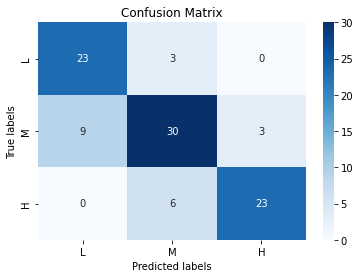

In [28]:
# sn.heatmap(cm, annot=True, cmap='Blues',xticklabels=['L','M','H'],yticklabels=['L','M','H'])

# plotting the values
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='d', ax=ax,cmap='Blues')  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['L','M','H']); ax.yaxis.set_ticklabels(['L','M','H']);

### ROC AUC curve

In [30]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

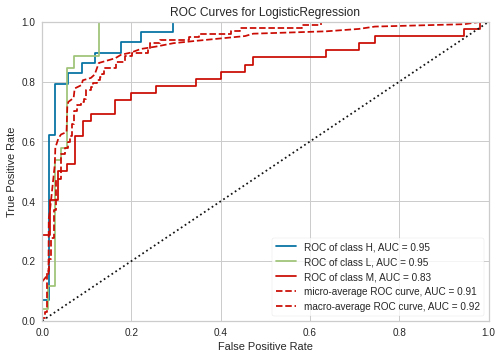

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=LogisticRegression())

In [31]:
plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

### Save Test Results

In [32]:
test_data['predictions'] = y_pred
test_data.to_csv('test_results/test_pred.csv',index=False)

### Analyse wrong predictions

In [33]:
test_data[test_data['Class']!=test_data['predictions']]

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class,predictions
11,M,Jordan,Jordan,lowerlevel,G-02,B,Arabic,F,Father,10.0,30,50,91,Yes,Bad,Above-7,L,M
17,F,Jordan,KuwaIT,MiddleSchool,G-08,C,Spanish,S,Father,87.0,88,40,10,Yes,Good,Under-7,M,H
22,M,Jordan,Jordan,lowerlevel,G-02,B,Arabic,F,Mum,15.0,90,21,97,Yes,Good,Under-7,M,H
28,M,KW,KuwaIT,lowerlevel,G-02,B,French,S,Father,40.0,62,83,33,Yes,Good,Under-7,H,M
30,M,KW,KuwaIT,MiddleSchool,G-08,B,Arabic,S,Father,25.0,5,12,33,Yes,Good,Under-7,M,L
34,M,Palestine,Jordan,MiddleSchool,G-06,A,English,S,Mum,92.0,31,42,27,Yes,Good,Under-7,H,M
37,F,Jordan,Jordan,MiddleSchool,G-08,A,Chemistry,F,Father,15.0,97,22,10,Yes,Good,Under-7,H,M
42,M,Jordan,Jordan,MiddleSchool,G-07,A,Quran,F,Mum,50.0,90,29,60,Yes,Good,Under-7,M,H
47,M,Jordan,Jordan,lowerlevel,G-02,A,French,F,Father,40.0,7,50,41,No,Good,Above-7,L,M
52,M,Jordan,Jordan,lowerlevel,G-02,A,French,S,Mum,50.0,90,83,13,Yes,Good,Under-7,H,M


# Final Conclution 